## **Catégorisez automatiquement des questions**

### partie 3/8 : Prédiction de tags, approche non-supervisée

#### <br> Proposition de mots clés, de type LDA avec visualisation en 2D des topics

<br>


## Importation des librairies, réglages


In [3]:
import os, sys, random
import ast
# from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from pprint import pprint

# Visualisation
import matplotlib.pyplot as plt
# import seaborn as sns
import plotly.express as px

# NLP
from bs4 import BeautifulSoup
import re, string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Feature engineering
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamulticore import LdaMulticore

from sklearn.model_selection import GridSearchCV

print('\nPython version ' + sys.version)
print('pyLDAvis version ' + pyLDAvis.__version__)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)



Python version 3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]
pyLDAvis version 3.4.0

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Fonctions


In [4]:
def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))



### import


In [5]:
# import

train = pd.read_csv('./../data/cleaned_data/train_bow_uniques.csv', sep=',')
test = pd.read_csv('./../data/cleaned_data/test_bow_uniques.csv', sep=',')

quick_look(train)


shape : (42898, 8)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
0,2019-06-05 15:13:02,How to use memset while handling strings in C++?,I am from Python background and recently learn...,"['c++', 'initialization', 'c-strings', 'string...","['memset', 'handle', 'string']","['memset', 'handle', 'string', 'python', 'back...","['use', 'memset', 'handle', 'string']","['background', 'learn', 'function', 'memset', ..."
1,2018-10-31 12:35:02,How to correct spelling in google docs using k...,I would like to be able to replace a misspelle...,"['gmail', 'keyboard-shortcuts', 'google-docs',...","['correct', 'spell', 'google', 'doc', 'keyboar...","['correct', 'spell', 'google', 'doc', 'shortcu...","['correct', 'spelling', 'keyboard', 'shortcut']","['like', 'replace', 'word', 'recommend', 'corr..."
2,2020-09-19 10:40:23,live server vscode on another computer,I have 2 computers. when I open the project wi...,"['visual-studio-code', 'server', 'localhost', ...","['server', 'vscode', 'computer']","['server', 'vscode', 'computer', 'open', 'proj...","['server', 'vscode', 'computer']","['computer', 'open', 'project', 'server', 'url..."
3,2012-10-23 16:47:04,django ajax post 403 forbidden,using django 1.4 im getting a 403 error when i...,"['javascript', 'ajax', 'django', 'http-post', ...","['django', 'ajax', 'forbidden']","['django', 'ajax', 'get', 'error', 'try', 'pos...",['forbid'],"['django', 'error', 'try', 'post', 'javascript..."
4,2019-04-21 16:10:24,Listen to changes and reload container on code...,I am using docker-compose in visual studio 201...,"['angular', 'visual-studio', 'docker', 'docker...","['listen', 'change', 'reload', 'container', 'c...","['listen', 'change', 'reload', 'container', 'c...","['listen', 'change', 'reload', 'container', 'c...","['docker', 'compose', 'studio', 'window', 'run..."


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
42893,2017-02-23 11:34:31,Do we need clear MDC after HTTP request in Spring,According to this answer thread local variable...,"['java', 'spring', 'logging', 'log4j', 'logback']","['need', 'mdc', 'request', 'spring']","['need', 'mdc', 'request', 'spring', 'accord',...","['need', 'request']","['accord', 'answer', 'thread', 'variable', 'us..."
42894,2011-10-13 20:57:32,How to make i18n with Handlebars.js (mustache ...,I'm currently using Handlebars.js (associated ...,"['javascript', 'jquery', 'internationalization...","['make', 'i18n', 'handlebar', 'template']","['make', 'i18n', 'handlebar', 'template', 'ass...",['template'],"['associate', 'web', 'app', 'client', 'render'..."
42895,2012-09-06 00:16:46,How can I make R read my environmental variables?,I am running R on EC2 spot instances and I nee...,"['linux', 'r', 'ubuntu', 'amazon-ec2', 'enviro...","['make', 'read', 'variable']","['make', 'read', 'variable', 'run', 'spot', 'i...","['read', 'variable']","['run', 'spot', 'instance', 'need', 'terminate..."
42896,2021-03-23 03:50:50,How to prevent react-query from fetching initi...,I'm using react-query v3.13 to fetch data from...,"['javascript', 'reactjs', 'fetch', 'react-quer...","['prevent', 'query', 'fetch', 'enable']","['prevent', 'query', 'fetch', 'enable', 'data'...","['prevent', 'react', 'query', 'fetch', 'enable']","['react', 'query', 'fetch', 'datum', 'want', '..."
42897,2016-03-17 04:19:15,Inserting into table with an Identity column w...,I have a table A_tbl in my database. I have cr...,"['sql', 'sql-server', 'database', 'ssms', 'dat...","['insert', 'table', 'identity', 'column', 'rep...","['insert', 'table', 'identity', 'column', 'rep...","['insert', 'table', 'column', 'replication', '...","['table', 'database', 'create', 'trigger', 'ca..."


uniques :


CreationDate    42893
title           42897
body            42898
all_tags        41513
title_nltk      42171
body_nltk       42898
title_spacy     37346
body_spacy      42891
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
CreationDate,CreationDate,0,42898,0.0,object
title,title,0,42898,0.0,object
body,body,0,42898,0.0,object
all_tags,all_tags,0,42898,0.0,object
title_nltk,title_nltk,0,42898,0.0,object
body_nltk,body_nltk,0,42898,0.0,object
title_spacy,title_spacy,0,42898,0.0,object
body_spacy,body_spacy,0,42898,0.0,object


In [6]:
# Tt semble OK, sauf les types : le fait d'exporter nos données a converti nos listes de tokens en str

def turn_str_back_into_list(df):
    """Correct the type change due to .csv export"""

    df['title_nltk'] = df['title_nltk'].apply(ast.literal_eval)
    df['body_nltk'] = df['body_nltk'].apply(ast.literal_eval)
    df['title_spacy'] = df['title_spacy'].apply(ast.literal_eval)
    df['body_spacy'] = df['body_spacy'].apply(ast.literal_eval)


turn_str_back_into_list(train)
turn_str_back_into_list(test)


In [7]:
# Vérif
train[['title_nltk', 'body_nltk', 'title_spacy', 'body_spacy']].map(len).describe()

# OK, pas de liste vide (min = 1)


,title_nltk,body_nltk,title_spacy,body_spacy
count,42898.000000,42898.000000,42898.000000,42898.000000
mean,4.409903,39.608653,3.311413,29.030444
std,1.732934,27.997950,1.619366,20.274162
min,1.000000,2.000000,1.000000,1.000000
25%,3.000000,21.000000,2.000000,16.000000
50%,4.000000,32.000000,3.000000,24.000000
75%,5.000000,50.000000,4.000000,37.000000
max,14.000000,368.000000,12.000000,307.000000


In [8]:
# quick_look(test)


In [9]:
test[['title_nltk', 'body_nltk', 'title_spacy', 'body_spacy']].map(len).describe()
# OK


,title_nltk,body_nltk,title_spacy,body_spacy
count,4767.000000,4767.000000,4767.000000,4767.000000
mean,4.395427,39.790854,3.284665,29.205160
std,1.716085,27.418228,1.620959,19.973006
min,1.000000,3.000000,1.000000,1.000000
25%,3.000000,21.000000,2.000000,16.000000
50%,4.000000,32.000000,3.000000,24.000000
75%,5.000000,51.000000,4.000000,37.000000
max,13.000000,268.000000,12.000000,194.000000


In [10]:
# Utile si nos inputs st sous forme de string
# mais il semble qu'on va plutôt conserver la liste de tokens au final

def fix_false_null_values(df):
    """
    Replace NaN values in specified columns with the string 'null'.
    ! USE ONLY AFTER VERIFYING that the NaN values are all the "null" string
    """
    df.loc[(df['title_nltk'].isna()), 'title_nltk'] = 'null'
    df.loc[(df['title_spacy'].isna()), 'title_spacy'] = 'null'


# fix_false_null_values(train)
# fix_false_null_values(test)

# Check for null values in the entire DataFrame
# null_values = train[train.isnull().any(axis=1)]

# Print the rows with null values
# print(null_values)


In [11]:
# quick_look(train)
# quick_look(test)


In [12]:
index = [4532, 8280, 12992, 14957, 22934, 24964, 25950]

display(train.loc[train.index.isin(index), :])

# OK


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
4532,2013-10-23 22:23:31,How to change type of id in Microsoft.AspNet.I...,"(ASP.NET MVC 5, EF6, VS2013)\nI'm trying to fi...","['asp.net-mvc', 'entity-framework', 'asp.net-m...","[change, type, aspnet, identity, entityframewo...","[change, type, aspnet, identity, entityframewo...","[change, type, identity]","[try, figure, change, type, field, string, int..."
8280,2014-06-20 18:46:09,"Bootstrap form input: prevent submit, but allo...",I've got the following problem: \nI use bootst...,"['javascript', 'jquery', 'html', 'forms', 'twi...","[bootstrap, form, input, submit, allow, checking]","[bootstrap, form, input, submit, allow, check,...","[bootstrap, form, input, prevent, submit, allo...","[problem, use, bootstrap, form, input, user, p..."
12992,2017-08-21 19:46:31,PySpark: org.apache.spark.sql.AnalysisExceptio...,"I'm trying to load Parquet data into PySpark, ...","['python', 'apache-spark', 'pyspark', 'apache-...","[pyspark, apache, spark, attribute, name, cont...","[pyspark, apache, spark, attribute, name, cont...","[org.apache.spark.sql, analysisexception, cont...","[try, load, datum, column, space, aliase, erro..."
14957,2018-08-08 12:58:34,How to break ForEach Loop in TypeScript,"I have a the below code, on which i am unable ...","['javascript', 'angular', 'typescript', 'forea...","[break, loop, typescript]","[break, loop, typescript, code, condition, fun...",[break],"[code, break, loop, condition, function, let, ..."
22934,2014-11-26 18:26:05,Python: Creating a 2D histogram from a numpy m...,"I'm new to python.\nI have a numpy matrix, of ...","['python', 'numpy', 'matrix', 'matplotlib', 'h...","[python, create, histogram, matrix]","[python, create, histogram, matrix, dimension,...","[python, create, histogram, matrix]","[python, matrix, dimension, value, range, want..."
24964,2011-11-28 02:41:21,SSRS line chart not connecting data points,I've looked high and low and can't seem to fin...,"['join', 'reporting-services', 'graph', 'chart...","[line, chart, connect, data, point]","[line, chart, connect, data, point, look, seem...","[line, chart, connect, datum, point]","[look, find, answer, appear, issue, think, lin..."
25950,2014-08-21 15:58:49,GS1 barcode parsing,We need to parse the GS1 datamatrix barcode wh...,"['parsing', 'barcode', 'datamatrix', 'gs1-data...","[barcode, parse]","[barcode, parse, need, provide, party, know, l...","[barcode, parse]","[need, parse, barcode, provide, party, know, u..."


## LDA


In [13]:
# add random state
# add grid search cv
# add other score ? silhouette ? ...

def suggest_topics_using_LDA(df, feature):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Set training parameters.
    num_topics = 10
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = gensim_dictionary[0]  # This is only to "load" the dictionary.
    id2word = gensim_dictionary.id2token

    model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

    top_topics = model.top_topics(corpus, topn=20)

    # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
    # = umass if same topn (default 20)
    avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
    print('Average topic coherence: %.4f.' % avg_topic_coherence)

    # Compute Coherence Score (Umass)
    coherence_umass = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='u_mass')
    coherence_lda_umass = coherence_umass.get_coherence()
    print('u_mass Coherence Score: %.4f.' % coherence_lda_umass)

    # Compute Coherence Score (cv)
    coherence_cv = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_v')
    coherence_lda_cv = coherence_cv.get_coherence()
    print('c_v Coherence Score: %.4f.' % coherence_lda_cv)

    # Compute Coherence Score (npmi)
    coherence_npmi = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_npmi')
    coherence_lda_npmi = coherence_npmi.get_coherence()
    print('c_npmi Coherence Score: %.4f.' % coherence_lda_npmi)

    # Perplexity is not a coherence score but a measure of how well the model predicts a sample.
    # A lower perplexity indicates better model performance.
    perplexity = model.log_perplexity(corpus)
    print('Perplexity: %.4f.' % perplexity)

    # Visualize the topics
    vis_data = gensimvis.prepare(model, corpus, gensim_dictionary)
    display(pyLDAvis.display(vis_data))

    # Uncomment the next line if you want to save the plot to a file
    # pyLDAvis.save_html(vis_data, 'lda_vis.html')

    pprint(top_topics)
    # to print all topics
    # pprint(model.print_topics())

    return model, corpus, gensim_dictionary

lda_test, corpus_test, dict_test = suggest_topics_using_LDA(train, 'title_nltk')


Average topic coherence: -8.8438.
u_mass Coherence Score: -8.8438.
c_v Coherence Score: 0.3638.
c_npmi Coherence Score: -0.1059.
Perplexity: -7.4090.


[([(0.0545867, 'get'),
   (0.04550065, 'python'),
   (0.035365924, 'string'),
   (0.034454472, 'data'),
   (0.03431738, 'value'),
   (0.032176767, 'java'),
   (0.025878029, 'function'),
   (0.025876753, 'type'),
   (0.025395049, 'array'),
   (0.024233172, 'object'),
   (0.020690972, 'list'),
   (0.020671079, 'convert'),
   (0.0201242, 'way'),
   (0.019365959, 'return'),
   (0.017968876, 'column'),
   (0.015222834, 'time'),
   (0.015007064, 'element'),
   (0.014493261, 'panda'),
   (0.01255736, 'query'),
   (0.012305898, 'dataframe')],
  -4.165533424890989),
 ([(0.07688184, 'error'),
   (0.043018874, 'find'),
   (0.030221177, 'run'),
   (0.027519457, 'app'),
   (0.02680604, 'window'),
   (0.024039123, 'fail'),
   (0.023207838, 'code'),
   (0.021847581, 'name'),
   (0.021774678, 'load'),
   (0.019550825, 'module'),
   (0.019391706, 'project'),
   (0.016744712, 'command'),
   (0.014965439, 'version'),
   (0.014449602, 'package'),
   (0.014425354, 'support'),
   (0.013516181, 'import'),
  

In [14]:
print(len(corpus_test)) # = nb documents (questions)
print(len(dict_test)) # = nb tokens uniques

# Get the Document-Topic Matrix
document_topic_matrix = lda_test.get_document_topics(corpus_test)

# Print the Document-Topic Matrix
for i, document_topics in enumerate(document_topic_matrix[:12]):
    print(f"Document {i + 1} Topics: {document_topics}")
print('\n')

# Get the Topic-Word Matrix
topic_word_matrix = lda_test.get_topics()

# Print the Topic-Word Matrix
for topic_id, topic_terms in enumerate(topic_word_matrix):
    term_weights = [(term_id, weight) for term_id, weight in enumerate(topic_terms)]
    terms_with_names = [(dict_test.id2token[term_id], weight) for term_id, weight in term_weights]
    print(f"Topic {topic_id + 1} Terms: {terms_with_names}")


42898
5869
Document 1 Topics: [(0, 0.053152043), (1, 0.3021685), (2, 0.0787524), (3, 0.062360663), (4, 0.059399825), (5, 0.051652476), (6, 0.06622498), (7, 0.19780678), (8, 0.07355162), (9, 0.054930735)]
Document 2 Topics: [(0, 0.042400025), (1, 0.10662514), (2, 0.06282174), (3, 0.049745847), (4, 0.047383953), (5, 0.31062457), (6, 0.052828465), (7, 0.1576917), (8, 0.12605967), (9, 0.043818906)]
Document 3 Topics: [(0, 0.053132664), (1, 0.133615), (2, 0.07872369), (3, 0.14673416), (4, 0.059378162), (5, 0.051633637), (6, 0.06620084), (7, 0.19769976), (8, 0.15797137), (9, 0.054910704)]
Document 4 Topics: [(0, 0.053138662), (1, 0.13363005), (2, 0.16318181), (3, 0.06234496), (4, 0.059384868), (5, 0.13589837), (6, 0.06620831), (7, 0.11330751), (8, 0.07353311), (9, 0.1393724)]
Document 5 Topics: [(0, 0.039716393), (1, 0.09987652), (2, 0.058845554), (3, 0.23596184), (4, 0.107476465), (5, 0.10170015), (6, 0.11260845), (7, 0.14780973), (8, 0.05495942), (9, 0.04104547)]
Document 6 Topics: [(0, 0.

In [15]:
# Du point de vue metier, des topics tres proches peuvent etre consideres
# comme etant un seul topic. Il est + interessant d'avoir des topics bien differents les uns des autres.

# Thought about using clustering scores like silhouette, davies-bouldin, etc...
# but lda is different from clustering, it returns not 1 label, but a distribution of probabilities over topics.
# so it's not possible to use davies-bouldin or silhouette directly to check if the topics are well separated.
# Instead, we can use a metric that evaluates the overlap between topics, such as the Jaccard similarity

topn = 1000

def jaccard_similarity(topic1, topic2):
    set1 = set(topic1)
    set2 = set(topic2)
    return len(set1.intersection(set2)) / len(set1.union(set2))

# Example
topic1 = lda_test.show_topic(0, topn=topn)
topn_tokens_topic1 = [token for token, proba in topic1]

print(topic1)
print(len(topic1))
print(topn_tokens_topic1)

topic2 = lda_test.show_topic(1, topn=topn)
topn_tokens_topic2 = [token for token, proba in topic2]

print(topic2)
print(len(topic2))
print(topn_tokens_topic2)

print('Jaccard Similarity between Topics 0 and 1:', jaccard_similarity(topn_tokens_topic1, topn_tokens_topic2))

# Pour avoir une idée sur l'ensemble des topics
def average_jaccard_similarity(lda_model):
    num_topics = lda_model.num_topics
    total_similarity = 0.0
    pair_count = 0

    # Iterate over all pairs of topics
    for i in range(num_topics):
        for j in range(i + 1, num_topics):
            # Get the word distributions for the two topics
            topic1 = lda_model.show_topic(i, topn=topn)
            topn_tokens_topic1 = [token for token, proba in topic1]
            topic2 = lda_model.show_topic(j, topn=topn)
            topn_tokens_topic2 = [token for token, proba in topic2]

            # Calculate Jaccard similarity and update total_similarity
            similarity = jaccard_similarity(topn_tokens_topic1, topn_tokens_topic2)
            total_similarity += similarity
            pair_count += 1

    # Calculate the average Jaccard similarity
    average_similarity = total_similarity / pair_count
    return average_similarity

# Example
average_jaccard = average_jaccard_similarity(lda_test)
print('Average Jaccard Similarity between Topics:', average_jaccard)


[('test', 0.06498698), ('framework', 0.030557184), ('react', 0.029685656), ('rail', 0.023455117), ('entity', 0.023334416), ('base', 0.022442013), ('component', 0.021891719), ('attribute', 0.02140199), ('mock', 0.01959665), ('unit', 0.018394727), ('implement', 0.01693725), ('loop', 0.014905453), ('typescript', 0.013098384), ('disable', 0.013057011), ('push', 0.01225095), ('style', 0.01174232), ('auto', 0.011491655), ('webpack', 0.011437676), ('interface', 0.010689635), ('expect', 0.010211374), ('vue', 0.0099055935), ('await', 0.009751472), ('render', 0.009743242), ('mode', 0.009477015), ('async', 0.009435879), ('parent', 0.009385526), ('root', 0.009165355), ('part', 0.008324119), ('keep', 0.007920422), ('receive', 0.0078630885), ('state', 0.0077725383), ('route', 0.007535922), ('jest', 0.007512535), ('draw', 0.007255787), ('range', 0.0068700267), ('decode', 0.006790588), ('transaction', 0.006593346), ('cmake', 0.0065281866), ('webdriver', 0.006244592), ('null', 0.006132648), ('coverage'

### Prediction


In [18]:
new_doc1 = "I have a python problem. I don't understand the difference between a slice and a copy."
new_doc2 = "I have a javascript problem. I don't understand the difference between a div and a span."
new_doc3 = "I like cookies."

# Preprocessing, identique à celui des autres docs

def preprocess_text(text):
    #Cleaning
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = text.lower().strip()

    # Tokenization
    try:
        tokens = nltk.word_tokenize(text)
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(" ".join(tokens))  # Apply RegexpTokenizer to the entire list

        # Remove punctuation (make sure, RegexpTokenizer should have done it already)
        tokens = [token for token in tokens if token not in string.punctuation]

    except Exception as e:
        print(f"Error in tokenization: {e}")
        return []

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    # Get part of speech for each token
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = []

    for token, pos_tag in pos_tags:
        # ! Uncommenting next line may crash the cell
        # print(f"Token: {token}, POS Tag: {pos_tag}")
        if pos_tag.startswith('V'):
            # On garde
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='v'))
            # Returns the input word unchanged if it cannot be found in WordNet.
        elif pos_tag.startswith('N'):
            # On garde
            try:
                lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='n'))
            except Exception as e:
                print(f"Error lemmatizing verb {token}: {e}")
        # Sinon on supprime

    # Read forbidden words (stopwords, too frequent, too rare) from the file
    with open('forbidden_words.txt', 'r') as file:
        forbidden = [line.strip() for line in file]

    filtered_list = [token for token in lemmatized_tokens if token not in forbidden]

    # keep uniques
    seen_tokens = set()
    unique_tokens = []

    for token in filtered_list:
        if token not in seen_tokens:
            seen_tokens.add(token)
            if len(token) > 2:
                unique_tokens.append(token)

    return unique_tokens


def predict_topics(text):
    # Tokenize and preprocess the new document
    new_doc_tokens = preprocess_text(text)  # Use the same preprocess function used during training

    # Convert the new document to a bag-of-words representation using the dictionary
    new_doc_bow = dict_test.doc2bow(new_doc_tokens)

    # Infer topic distribution for the new document
    topic_distribution = lda_test.get_document_topics(new_doc_bow)

    # Print the inferred topic distribution
    print(f"Inferred Topic Distribution for {str(text)}:")
    for topic_id, prob in topic_distribution:
        print(f"Topic {topic_id + 1}: Probability = {prob:.4f}")
    print('\n')

    # déterminer un seuil ?

predict_topics(new_doc1)
predict_topics(new_doc2)
predict_topics(new_doc3)


Inferred Topic Distribution for I have a python problem. I don't understand the difference between a slice and a copy.:
Topic 1: Probability = 0.1177
Topic 2: Probability = 0.1865
Topic 3: Probability = 0.0673
Topic 4: Probability = 0.1256
Topic 5: Probability = 0.0508
Topic 6: Probability = 0.0442
Topic 7: Probability = 0.1289
Topic 8: Probability = 0.0969
Topic 9: Probability = 0.0629
Topic 10: Probability = 0.1192


Inferred Topic Distribution for I have a javascript problem. I don't understand the difference between a div and a span.:
Topic 1: Probability = 0.0455
Topic 2: Probability = 0.1143
Topic 3: Probability = 0.2119
Topic 4: Probability = 0.0533
Topic 5: Probability = 0.0508
Topic 6: Probability = 0.0442
Topic 7: Probability = 0.1289
Topic 8: Probability = 0.0969
Topic 9: Probability = 0.1350
Topic 10: Probability = 0.1192


Inferred Topic Distribution for I like cookies.:
Topic 1: Probability = 0.0639
Topic 2: Probability = 0.1608
Topic 3: Probability = 0.0947
Topic 4: Prob

In [110]:
suggest_topics_using_LDA(train, 'title_spacy')


Average topic coherence: -6.750.
u_mass Coherence Score:  -10.16633824377779
c_v Coherence Score:  0.3706316567879477
c_npmi Coherence Score:  -0.15556503451384734
Perplexity:  -7.238181704353146


[([(0.09738355, 'error'),
   (0.06117362, 'find'),
   (0.041564025, 'run'),
   (0.038138967, 'fail'),
   (0.0375891, 'image'),
   (0.037310176, 'app'),
   (0.023743771, 'module'),
   (0.023466282, 'project'),
   (0.023415556, 'build'),
   (0.02155394, 'install')],
  -3.7955337931138344),
 ([(0.067816064, 'add'),
   (0.0677302, 'create'),
   (0.047050953, 'request'),
   (0.034949705, 'application'),
   (0.03417181, 'api'),
   (0.031159606, 'web'),
   (0.029467322, 'custom'),
   (0.026690599, 'ios'),
   (0.024985425, 'send'),
   (0.024789847, 'header')],
  -4.2101548036221015),
 ([(0.07102129, 'value'),
   (0.06570805, 'string'),
   (0.05285111, 'datum'),
   (0.05014124, 'array'),
   (0.043080803, 'convert'),
   (0.027112655, 'access'),
   (0.025102159, 'user'),
   (0.024977805, 'pass'),
   (0.024706002, 'form'),
   (0.024397347, 'update')],
  -5.318303782452968),
 ([(0.066774145, 'change'),
   (0.05008423, 'way'),
   (0.040715273, 'text'),
   (0.038419962, 'element'),
   (0.032871775, '

(<gensim.models.ldamodel.LdaModel at 0x7f181afbd390>,
 [[(0, 1), (1, 1), (2, 1), (3, 1)],
  [(4, 1), (5, 1), (6, 1), (7, 1)],
  [(8, 1), (9, 1), (10, 1)],
  [(11, 1)],
  [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)],
  [(19, 1), (20, 1), (21, 1)],
  [(22, 1)],
  [(23, 1), (24, 1), (25, 1)],
  [(26, 1), (27, 1), (28, 1)],
  [(29, 1), (30, 1), (31, 1), (32, 1)],
  [(33, 1), (34, 1)],
  [(35, 1)],
  [(36, 1), (37, 1), (38, 1), (39, 1)],
  [(40, 1), (41, 1), (42, 1)],
  [(12, 1), (43, 1)],
  [(44, 1), (45, 1)],
  [(27, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)],
  [(51, 1), (52, 1), (53, 1), (54, 1)],
  [(55, 1), (56, 1), (57, 1), (58, 1), (59, 1)],
  [(9, 1), (13, 1), (26, 1), (28, 1), (49, 1), (60, 1), (61, 1), (62, 1)],
  [(12, 1), (63, 1), (64, 1)],
  [(65, 1), (66, 1), (67, 1), (68, 1), (69, 1)],
  [(70, 1), (71, 1)],
  [(33, 1), (60, 1), (64, 1), (72, 1)],
  [(73, 1)],
  [(74, 1)],
  [(75, 1), (76, 1), (77, 1), (78, 1), (79, 1)],
  [(80, 1), (81, 1)],
  [(27, 

In [111]:
lda_test, corpus_test, dict_test = suggest_topics_using_LDA(train, 'body_nltk')

# Score un peu meilleur
# (sauf perplexité, similaire)
# mais les topics sont bien mieux différentiés !

# analyse a developper


Average topic coherence: -1.693.
u_mass Coherence Score:  -1.9204137041631686
c_v Coherence Score:  0.6585732750447372
c_npmi Coherence Score:  0.059319199656616486
Perplexity:  -7.232457244775426


[([(0.023325562, 'get'),
   (0.023011025, 'return'),
   (0.020105002, 'string'),
   (0.020003214, 'value'),
   (0.018746082, 'try'),
   (0.01786467, 'code'),
   (0.016653446, 'class'),
   (0.016168797, 'data'),
   (0.014330446, 'name'),
   (0.01328787, 'function')],
  -1.2575322340034594),
 ([(0.036608372, 'file'),
   (0.026445713, 'error'),
   (0.022631582, 'run'),
   (0.019928072, 'version'),
   (0.017414253, 'try'),
   (0.017098943, 'project'),
   (0.016724398, 'get'),
   (0.01670465, 'command'),
   (0.016152998, 'build'),
   (0.014413662, 'package')],
  -1.381295950820217),
 ([(0.027367882, 'java'),
   (0.023377953, 'spring'),
   (0.018243967, 'org'),
   (0.016142398, 'xml'),
   (0.015233912, 'lang'),
   (0.014754045, 'class'),
   (0.012200265, 'annotation'),
   (0.011746639, 'boot'),
   (0.011067106, 'com'),
   (0.00997688, 'exception')],
  -1.4050787530187625),
 ([(0.01710359, 'work'),
   (0.015046704, 'way'),
   (0.01481001, 'need'),
   (0.014791683, 'find'),
   (0.013810537, 'm

In [112]:
average_jaccard = average_jaccard_similarity(lda_test)
print('Average Jaccard Similarity between Topics:', average_jaccard)

# OK


Average Jaccard Similarity between Topics: 0.07379607191091762


In [113]:
suggest_topics_using_LDA(train, 'body_spacy')


Average topic coherence: -1.954.
u_mass Coherence Score:  -2.3550459429632187
c_v Coherence Score:  0.7128007392311121
c_npmi Coherence Score:  0.07440045842700452
Perplexity:  -7.062042962005138


[([(0.03573449, 'use'),
   (0.025354477, 'work'),
   (0.025089238, 'way'),
   (0.024468334, 'need'),
   (0.021146214, 'find'),
   (0.02104318, 'want'),
   (0.020052418, 'know'),
   (0.017162958, 'look'),
   (0.01581032, 'problem'),
   (0.015306427, 'thank')],
  -1.521364369254603),
 ([(0.040403295, 'file'),
   (0.036238458, 'error'),
   (0.035855368, 'run'),
   (0.023430556, 'try'),
   (0.020638153, 'project'),
   (0.019044356, 'version'),
   (0.018535534, 'build'),
   (0.015798865, 'fail'),
   (0.014345089, 'follow'),
   (0.01429377, 'command')],
  -1.5306544989523536),
 ([(0.02451313, 'spring'),
   (0.02346848, 'annotation'),
   (0.020245597, 'configuration'),
   (0.015179677, 'boot'),
   (0.014448585, 'dependency'),
   (0.013920053, 'bean'),
   (0.013344332, 'class'),
   (0.013338306, 'property'),
   (0.012909644, 'exception'),
   (0.011625976, 'xml')],
  -1.6129435893050572),
 ([(0.042881142, 'try'),
   (0.035093907, 'code'),
   (0.03288134, 'return'),
   (0.032835472, 'function'),

(<gensim.models.ldamodel.LdaModel at 0x7f17ea97d610>,
 [[(0, 1),
   (1, 1),
   (2, 1),
   (3, 1),
   (4, 1),
   (5, 1),
   (6, 1),
   (7, 1),
   (8, 1),
   (9, 1),
   (10, 1),
   (11, 1),
   (12, 1),
   (13, 1),
   (14, 1),
   (15, 1),
   (16, 1),
   (17, 1),
   (18, 1),
   (19, 1),
   (20, 1),
   (21, 1),
   (22, 1),
   (23, 1),
   (24, 1),
   (25, 1),
   (26, 1),
   (27, 1),
   (28, 1),
   (29, 1),
   (30, 1),
   (31, 1),
   (32, 1),
   (33, 1),
   (34, 1),
   (35, 1),
   (36, 1),
   (37, 1)],
  [(38, 1),
   (39, 1),
   (40, 1),
   (41, 1),
   (42, 1),
   (43, 1),
   (44, 1),
   (45, 1),
   (46, 1),
   (47, 1),
   (48, 1),
   (49, 1),
   (50, 1)],
  [(50, 1),
   (51, 1),
   (52, 1),
   (53, 1),
   (54, 1),
   (55, 1),
   (56, 1),
   (57, 1),
   (58, 1)],
  [(13, 1),
   (16, 1),
   (29, 1),
   (31, 1),
   (50, 1),
   (55, 1),
   (57, 1),
   (58, 1),
   (59, 1),
   (60, 1),
   (61, 1),
   (62, 1),
   (63, 1),
   (64, 1),
   (65, 1),
   (66, 1),
   (67, 1),
   (68, 1),
   (69, 1),
   (7

### Multicore


In [22]:
# add random state
# add grid search cv

def suggest_topics_using_LDA(df, feature, num_topics):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Set training parameters.
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = gensim_dictionary[0]  # This is only to "load" the dictionary.
    id2word = gensim_dictionary.id2token

    # Create model, fit it on corpus
    model = LdaMulticore(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

    # Compute Coherence Score (Umass)
    coherence_umass = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='u_mass')
    coherence_lda_umass = coherence_umass.get_coherence()
    print('u_mass Coherence Score: %.4f.' % coherence_lda_umass)

    # Compute Coherence Score (cv)
    coherence_cv = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_v')
    coherence_lda_cv = coherence_cv.get_coherence()
    print('c_v Coherence Score: %.4f.' % coherence_lda_cv)

    # Compute Coherence Score (npmi)
    coherence_npmi = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_npmi')
    coherence_lda_npmi = coherence_npmi.get_coherence()
    print('c_npmi Coherence Score: %.4f.' % coherence_lda_npmi)


    # similarité des topics obtenus
    average_jaccard = average_jaccard_similarity(model)
    print('Average Jaccard Similarity between Topics:', average_jaccard)

    # Visualize the topics
    vis_data = gensimvis.prepare(model, corpus, gensim_dictionary)
    display(pyLDAvis.display(vis_data))

    # Uncomment the next line if you want to save the plot to a file
    # pyLDAvis.save_html(vis_data, 'lda_vis.html')

    # scores
    scores = [coherence_lda_umass, coherence_lda_cv, coherence_lda_npmi, average_jaccard]

    return model, corpus, gensim_dictionary, scores

lda_test, corpus_test, dict_test, scores_test = suggest_topics_using_LDA(train, 'body_nltk', 10)
# On gagne + d'1 min


u_mass Coherence Score: -1.6496.
c_v Coherence Score: 0.5510.
c_npmi Coherence Score: 0.0275.
Average Jaccard Similarity between Topics: 0.25396895946119635


### Hyperparameters tuning


nb de topics : 3
u_mass Coherence Score: -4.8266.
c_v Coherence Score: 0.2479.
c_npmi Coherence Score: -0.0179.
Average Jaccard Similarity between Topics: 0.13850400481264433


nb de topics : 5
u_mass Coherence Score: -5.5884.
c_v Coherence Score: 0.2382.
c_npmi Coherence Score: -0.0342.
Average Jaccard Similarity between Topics: 0.13310693924296252


nb de topics : 7
u_mass Coherence Score: -5.2753.
c_v Coherence Score: 0.2987.
c_npmi Coherence Score: 0.0017.
Average Jaccard Similarity between Topics: 0.09582814629764298


nb de topics : 9
u_mass Coherence Score: -6.3861.
c_v Coherence Score: 0.2973.
c_npmi Coherence Score: -0.0315.
Average Jaccard Similarity between Topics: 0.09236427752736202


nb de topics : 11
u_mass Coherence Score: -6.8645.
c_v Coherence Score: 0.3124.
c_npmi Coherence Score: -0.0454.
Average Jaccard Similarity between Topics: 0.13671651201093588


nb de topics : 13
u_mass Coherence Score: -7.3402.
c_v Coherence Score: 0.3449.
c_npmi Coherence Score: -0.0557.
Average Jaccard Similarity between Topics: 0.17665975392020364


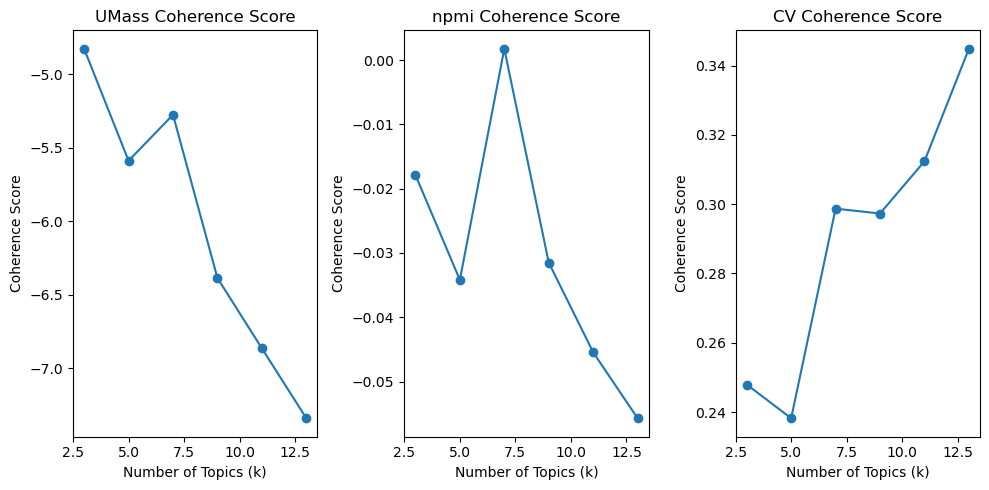

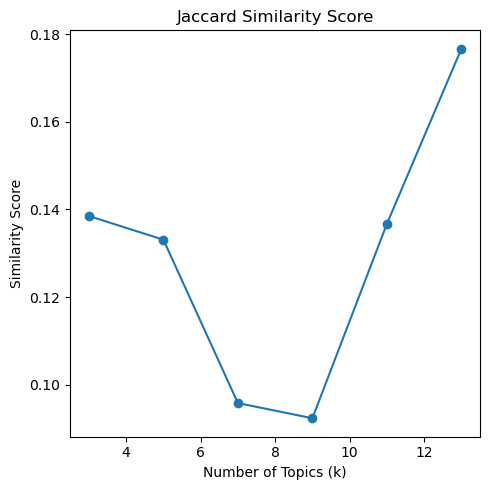

In [24]:
# Choix du nb de topics k
# Contrainte métier : k pas trop élevé, car difficile de comprendre/nommer les topics

umass_results = []
cv_results = []
npmi_results = []
jacc_results = []


for i in range(3, 14, 2):
    print(f'nb de topics : {i}')
    lda_test, corpus_test, dict_test, scores_test = suggest_topics_using_LDA(train, 'title_nltk', i)
    umass_results.append(scores_test[0])
    cv_results.append(scores_test[1])
    npmi_results.append(scores_test[2])
    jacc_results.append(scores_test[3])


# Plotting UMass Coherence Score
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(range(3, 14, 2), umass_results, marker='o')
plt.title('UMass Coherence Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score')

# Plotting npmi Coherence Score
plt.subplot(1, 3, 2)
plt.plot(range(3, 14, 2), npmi_results, marker='o')
plt.title('npmi Coherence Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score')

# Plotting CV Coherence Score
plt.subplot(1, 3, 3)
plt.plot(range(3, 14, 2), cv_results, marker='o')
plt.title('CV Coherence Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score')

plt.tight_layout()
plt.show()

# Plotting Jaccard Similarity Score
plt.figure(figsize=(5, 5))
plt.plot(range(3, 14, 2), jacc_results, marker='o')
plt.title('Jaccard Similarity Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Similarity Score')

plt.tight_layout()
plt.show()


In [ ]:
# problem : augmenter le nb de topics revient à overfitter le modele,
# ce qui penalise umass et npmi et favorise c_v (on le voit bien sur les 3 premieres courbes, en haut)
# En revanche les resultats pour la similarté (en bas) sont plus faciles à interpréter.

# Ici entre la méthode du coude sur umass (k=7), npmi (k=7) et cv (k=7)
# + minimum jaccard (k=9),
# je prendrais k=7 ou k=9 comme nombre opti de topics, selon qu'on préfère + ou - précis

# c un nombre raisonnable, qui nous donne les topics les mieux différenciés
# (d'après Jaccard)
# et les + cohérents (autres scores)


## tfidf + nmf


## Word2Vec + K-Means ?


## doc2vec


## LSA ? = tfidf + svd
